In [1]:
# import the necessary packages
from imutils.perspective import four_point_transform
from imutils import contours
import imutils
import cv2
# Create figure and axes
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# define the dictionary of digit segments so we can identify
# each digit on the thermostat
DIGITS_LOOKUP = {
	(1, 1, 1, 0, 1, 1, 1): 0,
	(0, 0, 1, 0, 0, 1, 0): 1,
	(1, 0, 1, 1, 1, 0, 1): 2,
	(1, 0, 1, 1, 0, 1, 1): 3,
	(0, 1, 1, 1, 0, 1, 0): 4,
	(1, 1, 0, 1, 0, 1, 1): 5,
	(1, 1, 0, 1, 1, 1, 1): 6,
	(1, 0, 1, 0, 0, 1, 0): 7,
	(1, 1, 1, 1, 1, 1, 1): 8,
	(1, 1, 1, 1, 0, 1, 1): 9
}

# load the example image
image = cv2.imread("/home/jessica/reading-kiln-termostat/data/recordings/test_results/grey_best_mask_corrected/01-08-2024-esmalte/prediction_frames/2024-08-01_22:30:00_1161_1152.png")
print(image.shape[2])
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


# pre-process the image by resizing it, converting it to
# graycale, blurring it, and computing an edge map

3


In [12]:
# find contours in the thresholded image, then initialize the
# digit contours lists
cnts = cv2.findContours(image.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
digitCnts = []
# loop over the digit area candidates
for c in cnts:
    (x, y, w, h) = cv2.boundingRect(c)
    print(x,y,w,h)
    if w >= 8 and (h >= 15 and h <= 100):
        digitCnts.append(c)
        
len(digitCnts)

126 73 2 1
188 65 1 1
44 64 1 1
99 45 10 20
59 44 10 20
204 25 1 2
103 24 10 20
62 24 11 18
161 22 36 50
119 21 33 49
203 17 2 1


6

In [13]:
rectangles = [cv2.boundingRect(c) for c in digitCnts] 

# Function to merge two rectangles if they overlap or are close vertically
# Function to merge two rectangles if they are horizontally aligned or close
def merge_rects_horizontally(rect1, rect2):
    x1, y1, w1, h1 = rect1
    x2, y2, w2, h2 = rect2
    
    # Check if the rectangles have some horizontal overlap or are close enough horizontally
    if not (x1 + w1 < x2 or x2 + w2 < x1):
        # Combine them into a single rectangle that spans both horizontally
        new_x = min(x1, x2)
        new_y = min(y1, y2)
        new_w = max(x1 + w1, x2 + w2) - new_x
        new_h = max(y1 + h1, y2 + h2) - new_y
        return (new_x, new_y, new_w, new_h)
    else:
        return None

# Sort the rectangles by their x-coordinate (left to right)
rectangles = sorted(rectangles, key=lambda r: r[0])

# List to store the merged rectangles
merged_rectangles = []

# Iterate through the rectangles and merge the ones side by side
i = 0
while i < len(rectangles):
    current_rect = rectangles[i]
    for j in range(i + 1, len(rectangles)):
        merged = merge_rects_horizontally(current_rect, rectangles[j])
        if merged:
            current_rect = merged  # Update the current rectangle
            i = j  # Move the index to skip the merged rectangle
        else:
            break  # Stop if no more merging is possible
    merged_rectangles.append(current_rect)
    i += 1

# Output the merged rectangles
for rect in merged_rectangles:
    print(rect)


(59, 24, 14, 40)
(99, 24, 14, 41)
(119, 21, 33, 49)
(161, 22, 36, 50)


560
574
1617
[1, 1, 0, 1, 1, 1, 1]
1800
[1, 0, 1, 1, 1, 0, 1]
[1, 1, 6, 2]


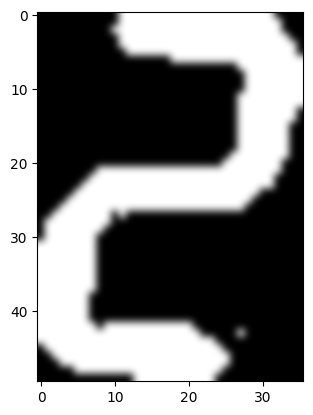

In [14]:
# sort the contours from left-to-right, then initialize the
# actual digits themselves
digits = []
# Add four point transform 
# image = four_point_transform(image, image.reshape(4, 2))

# loop over each of the digits
for c in merged_rectangles:
    # extract the digit ROI
    (x, y, w, h) = c
    area = w * h
    print(area)
    if(area < 200):
        continue
    else:
        if (area < 800):
            digits.append(1)
            continue
    roi = image[y:y + h, x:x + w]
    plt.imshow(roi, cmap = 'gray', interpolation = 'bicubic')
    # compute the width and height of each of the 7 segments
    # we are going to examine
    (roiH, roiW) = roi.shape
    (dW, dH) = (int(roiW * 0.50), int(roiH * 0.15))
    dHC = int(roiH * 0.05)
    # define the set of 7 segments
    segments = [
        ((0, 0), (w, dH)),	# top
        ((0, 0), (dW, h // 2)),	# top-left
        ((w - dW, 0), (w, h // 2)),	# top-right
        ((0, (h // 2) - dHC) , (w, (h // 2) + dHC)), # center
        ((0, h // 2), (dW, h)),	# bottom-left
        ((w - dW, h // 2), (w, h)),	# bottom-right
        ((0, h - dH), (w, h))	# bottom
    ]
    on = [0] * len(segments)
    
#     print(segments)
    for (i, ((xA, yA), (xB, yB))) in enumerate(segments):
        # extract the segment ROI, count the total number of
        # thresholded pixels in the segment, and then compute
        # the area of the segment
        segROI = roi[yA:yB, xA:xB]
        total = cv2.countNonZero(segROI)
        area = (xB - xA) * (yB - yA)
        # if the total number of non-zero pixels is greater than
        # 50% of the area, mark the segment as "on"
        try:
            if total / float(area) > 0.5:
                on[i]= 1
        except: 
            on[i] = 0

        # lookup the digit and draw it on the image
    print(on)
    try:
        digit = DIGITS_LOOKUP[tuple(on)]
    except:
        digit = 0
    digits.append(digit)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 1)
    cv2.putText(image, str(digit), (x - 10, y - 10),
        cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)
print(digits)

In [12]:
prediction = int("".join(map(str, digits)))
prediction

1162

[(59, 24, 14, 40),
 (77, 19, 36, 50),
 (118, 20, 37, 51),
 (163, 22, 34, 50),
 (203, 17, 3, 10)]

In [14]:
# loop over the segments
for (i, ((xA, yA), (xB, yB))) in enumerate(segments):
    print(i)
    # extract the segment ROI, count the total number of
    # thresholded pixels in the segment, and then compute
    # the area of the segment
    segROI = roi[yA:yB, xA:xB]
    total = cv2.countNonZero(segROI)
    area = (xB - xA) * (yB - yA)
    # if the total number of non-zero pixels is greater than
    # 50% of the area, mark the segment as "on"
    if total / float(area) > 0.5:
        on[i]= 1
        
# lookup the digit and draw it on the image
digit = DIGITS_LOOKUP[tuple(on)]
digits.append(digit)
cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 1)
cv2.putText(output, str(digit), (x - 10, y - 10),
    cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)

0
1


ZeroDivisionError: float division by zero

In [121]:
rectangles = [cv2.boundingRect(c) for c in cnts] 

# Function to merge two rectangles if they are horizontally aligned or close
def merge_rects_horizontally(rect1, rect2):
    x1, y1, w1, h1 = rect1
    x2, y2, w2, h2 = rect2
    
    # Check if the rectangles have some horizontal overlap or are close enough horizontally
    if not (x1 + w1 < x2 or x2 + w2 < x1):
        # Combine them into a single rectangle that spans both horizontally
        new_x = min(x1, x2)
        new_y = min(y1, y2)
        new_w = max(x1 + w1, x2 + w2) - new_x
        new_h = max(y1 + h1, y2 + h2) - new_y
        return (new_x, new_y, new_w, new_h)
    else:
        return None

# Sort the rectangles by their x-coordinate (left to right)
rectangles = sorted(rectangles, key=lambda r: r[0])

# List to store the merged rectangles
merged_rectangles = []

# Iterate through the rectangles and merge the ones side by side
i = 0
while i < len(rectangles):
    current_rect = rectangles[i]
    for j in range(i + 1, len(rectangles)):
        merged = merge_rects_horizontally(current_rect, rectangles[j])
        if merged:
            current_rect = merged  # Update the current rectangle
            i = j  # Move the index to skip the merged rectangle
        else:
            break  # Stop if no more merging is possible
    merged_rectangles.append(current_rect)
    i += 1

# Output the merged rectangles
for rect in merged_rectangles:
    print(rect)


(42, 21, 31, 41)
(78, 22, 33, 41)
(116, 23, 32, 41)
(25, 25, 12, 33)


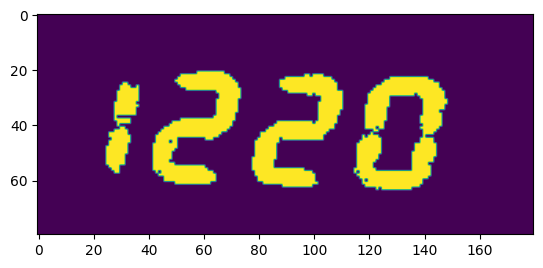

In [120]:

## Draw contours 
plt.imshow(image)


In [28]:
cv2.boundingRect(cnts[0])

(177, 55, 10, 23)

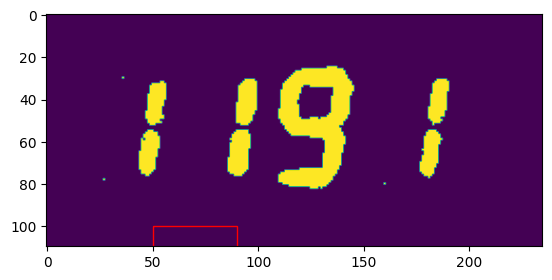

In [25]:
# Create figure and axes
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

im = Image.open("/home/jessica/reading-kiln-termostat/data/recordings/test_results/grey_best_mask/29-08-2024-esmalte/prediction_frames/2024-08-29_23:16:56_1191_1191.png")
fig, ax = plt.subplots()

# Display the image
ax.imshow(im)

# Create a Rectangle patch
rect = patches.Rectangle((177, 100), 40, 30, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

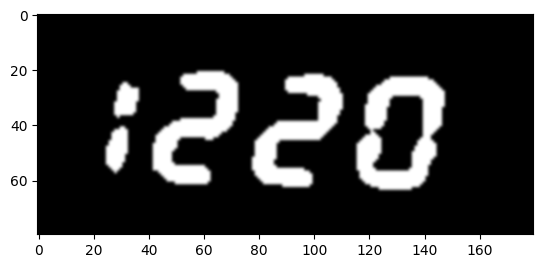

In [90]:
import matplotlib.pyplot as plt 
plt.imshow(blurred, cmap = 'gray', interpolation = 'bicubic')


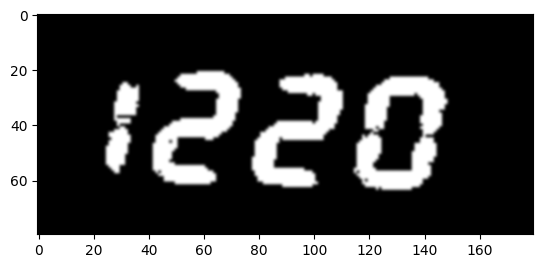

In [74]:
plt.imshow(image, cmap = 'gray', interpolation = 'bicubic')
